In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/GitHub/dimerEnhanceProteinDNA')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

In [4]:
def readGillespieSurvP(filename):
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

def resample_time_sequence(sequence, dt):
    """
    Sample from the input sequence to ensure time steps are at least `dt` apart.

    Parameters:
        sequence (list): A list of increasing numbers.
        dt (float): Minimum time step between sampled values.

    Returns:
        tuple: A tuple containing:
            - list: A new sequence with time steps at least `dt` apart.
            - list: Indices of the sampled values in the original sequence.
    """
    # Initialize the sampled sequence and indices with the first element
    sampled = [sequence[0]]
    indices = [0]

    # Iterate through the input sequence and add elements that satisfy the condition
    for idx, value in enumerate(sequence):
        if value - sampled[-1] >= dt:
            sampled.append(value)
            indices.append(idx)

    return np.array(sampled), np.array(indices)

def getPDF(fileName, timeStep=0.01):
    times, survP, meanResT, numDiss  = readGillespieSurvP(fileName)
    timeX_origin, timeIdx = resample_time_sequence(times, dt=timeStep)
    timeX = (timeX_origin[1:]+timeX_origin[:-1])/2
    dTimeX = np.diff(timeX_origin)
    probY = -np.diff(survP[timeIdx])
    print(meanResT)
    return timeX, probY/dTimeX

In [5]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    onRate = (kbPS*chiS + kbPN*chiN)
    return (onRate*gamma*chiN*2)/(1 + gamma*chiN)/chiS

# For DNA+targ

## Generate simulations

In [6]:
# Run this cell for new simulations

GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[30], kbPP_fixed=kbP,
    KPP=[0, 1e6, 1e9],
)

parm_num = GenParms(0.055, 0)

print('Critical Rate k*', criticalRate(GenParms(1, 0)))

equi_num = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

from pathlib import Path

fileprefix = './Simulations/DNAtarg:criticDimer/'
Path(fileprefix).mkdir(parents=True, exist_ok=True)
parm_num.to_csv(fileprefix+'/parameters.csv')
equi_num.to_csv(fileprefix+'/equilibrium.csv')

Critical Rate k* [0.10003831 0.10003831 0.10003831]
2025-07-01 12:48:09.593464
Number of cores used:  3/36
Finished parallel processing.


## pdf of residence time

101.79
0.9997735322106681
101.9
0.998334896772272
103.0
0.9991296169546723


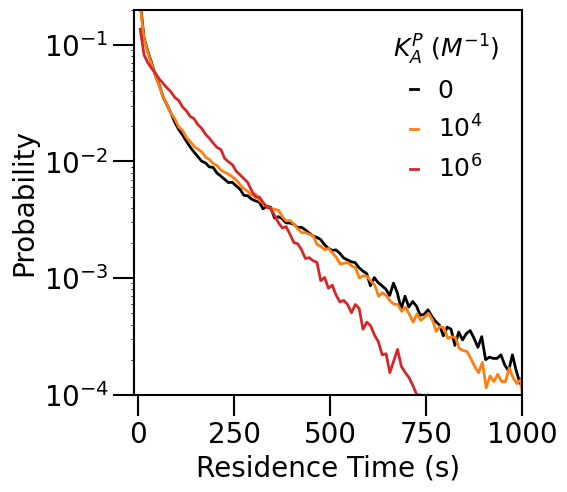

In [7]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{A}^{P}\ (M^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)

KPPlog10 = ['0', '$10^4$', '$10^6$']
fileIndex = [0, 1, 2]
lineColors = ['black', 'tab:orange', 'tab:red']
lineStyles = ['-', '--', ':']
tSampleStep = 10

for i in range(3):
    fileName = fileprefix + f'/out_{fileIndex[i]}_r0'
    timeX, probY  = getPDF(fileName, timeStep=tSampleStep)
    plt.plot(
        timeX, probY*tSampleStep, lw=2, color=lineColors[i], 
        ls=lineStyles[0], label=KPPlog10[fileIndex[i]],
    )
    print(np.sum(probY*tSampleStep))

# timePoints = np.linspace(0,2000)
# plt.plot(timePoints[1:], -np.diff(monomerDwellPDF(timePoints, parm_num)))
    
plt.legend(**legend)
plt.xlim([-10,1000])
plt.ylim([1e-4, 2e-1])
plt.semilogy()

plt.xlabel('Residence Time (s)', **labelfont)
plt.ylabel('Probability', **labelfont)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.locator_params(axis='x', nbins=5)

plt.show()

## survival probability

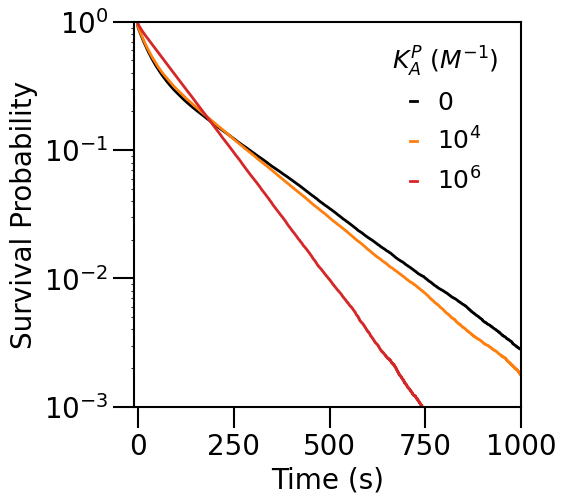

In [8]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{A}^{P}\ (M^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)

KPPlog10 = ['0', '$10^4$', '$10^6$']
fileIndex = [0, 1, 2]
lineColors = ['black', 'tab:orange', 'tab:red']
lineStyles = ['-', '--', ':']
tSampleStep = 10

for i in range(3):
    fileName = fileprefix + f'/out_{fileIndex[i]}_r0'
    times, survP, meanResT, numDiss  = readGillespieSurvP(fileName)
    plt.plot(
        times, survP, lw=2, color=lineColors[i], 
        ls=lineStyles[0], label=KPPlog10[fileIndex[i]],
    )

    
plt.legend(**legend)
plt.xlim([-10,1000])
plt.ylim([1e-3, 1])
plt.semilogy()

plt.xlabel('Time (s)', **labelfont)
plt.ylabel('Survival Probability', **labelfont)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.locator_params(axis='x', nbins=5)

plt.show()

# a) and c) For DNA

In [9]:
# Run this cell for new simulations

GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=0, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[100], kbPP_fixed=kbP,
    KPP=[0, 1e3, 1e4],
)

parm_num = GenParms(1, 0)

print('Critical Rate k*', criticalRate(GenParms(1, 0)))

equi_num = numericSolver(parm_df=parm_num, labels=labelsNonly, model=rxnNonly)

from pathlib import Path

fileprefix = './Simulations/DNA:criticDimer/'
Path(fileprefix).mkdir(parents=True, exist_ok=True)
parm_num.to_csv(fileprefix+'/parameters.csv')
equi_num.to_csv(fileprefix+'/equilibrium.csv')

Critical Rate k* [1.14285714 1.14285714 1.14285714]
2025-07-01 12:49:08.500876
Number of cores used:  3/36
Finished parallel processing.


## pdf of residence time

1.6593
0.9994135716677269
1.6994
0.9992568039275463
1.7689
0.9951912244045684


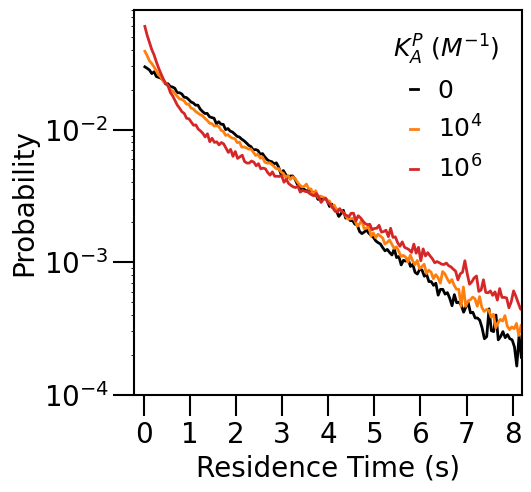

In [10]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{A}^{P}\ (M^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)

KPPlog10 = ['0', '$10^3$', '$10^4$', '$10^5$', '$10^6$']
fileIndex = [0, 2, 4]
lineColors = ['black', 'tab:orange', 'tab:red']
lineStyles = ['-', '--', ':']
j = 0
tSampleStep = 0.05

for i in range(3):
    fileName = fileprefix + f'/out_{fileIndex[i]+4*j}_r0'
    timeX, probY  = getPDF(fileName, timeStep=tSampleStep)
    plt.plot(
        timeX, probY*tSampleStep, lw=2,
        color=lineColors[i], 
        ls=lineStyles[0],
        label=KPPlog10[fileIndex[i]],
    )
    print(np.sum(probY*tSampleStep))

plt.legend(**legend)
plt.xlim([-0.2,8.2])
plt.ylim([1e-4,8e-2])
plt.semilogy()

plt.xlabel('Residence Time (s)', **labelfont)
plt.ylabel('Probability', **labelfont)
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.show()

## survival probability

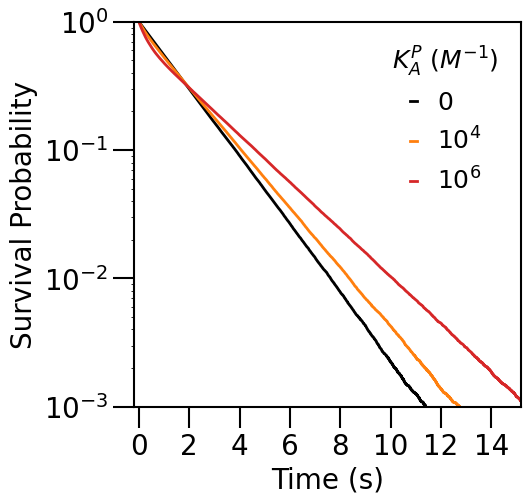

In [11]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{A}^{P}\ (M^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)

KPPlog10 = ['0', '$10^3$', '$10^4$', '$10^5$', '$10^6$']
fileIndex = [0, 2, 4]
lineColors = ['black', 'tab:orange', 'tab:red']
lineStyles = ['-', '--', ':']
j = 0
tSampleStep = 0.05

for i in range(3):
    fileName = fileprefix + f'/out_{fileIndex[i]+4*j}_r0'
    times, survP, meanResT, numDiss  = readGillespieSurvP(fileName)
    plt.plot(
        times, survP, lw=2, color=lineColors[i], 
        ls=lineStyles[0], label=KPPlog10[fileIndex[i]],
    )

plt.legend(**legend)
plt.xlim([-0.2,15.2])
plt.ylim([1e-3,1])
plt.semilogy()

plt.xlabel('Time (s)', **labelfont)
plt.ylabel('Survival Probability', **labelfont)
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.show()